In [1]:
%matplotlib inline

## [Feature Extraction - Text](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)
- Scikit provides text-to-numerical feature extraction utilities to aid *tokenization*, *counting* and *normalizing* functions.
- A document corpus is defined as a matrix with one row per document and one column per token (word) that occurs in the corpus.
- Most corpus examples use small subsets of the total words available, so the resulting matrix will be very sparse. Scikit uses ```scipy.sparse``` to aid computations.

In [20]:
# CountVectorizer handles tokenization & occurrence counting.

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
corpus = [
    'This is the first document.',
    'This is the second second document.',
    'And the third one.',
    'Is this the first document?',
]
# tokenize & count word occurrences
X = vectorizer.fit_transform(corpus)
X

<4x9 sparse matrix of type '<class 'numpy.int64'>'
	with 19 stored elements in Compressed Sparse Row format>

In [21]:
# default configuration: extract words of at least 2 letters.
analyze = vectorizer.build_analyzer()
analyze("This is a text document to analyze.") == (
    ['this', 'is', 'text', 'document', 'to', 'analyze'])

True

In [22]:
vectorizer.get_feature_names() == (
    ['and', 'document', 'first', 'is', 'one',
     'second', 'the', 'third', 'this'])

X.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 2, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]])

In [23]:
# feature name : column index map is stored in vocabulary_
vectorizer.vocabulary_.get('document')

1

In [24]:
# words not seen in training corpus will be ignored.
vectorizer.transform(['Something completely new.']).toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [25]:
# previous corpus: 1st & last docs = same #words, 
# so encoded into equal vectors.
# we lose track of last doc being a question.
# to preserve some local ordering info, we can use 2-grams.

bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),
                                    token_pattern=r'\b\w+\b', min_df=1)
analyze = bigram_vectorizer.build_analyzer()
analyze('Bi-grams are cool!') == (
    ['bi', 'grams', 'are', 'cool', 'bi grams', 'grams are', 'are cool'])

True

In [26]:
# this vectorizer has a much bigger array.
X_2 = bigram_vectorizer.fit_transform(corpus).toarray()
X_2

array([[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0, 1, 1, 0, 0, 2, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1]])

In [27]:
# now we can check for the question phrase..
feature_index = bigram_vectorizer.vocabulary_.get('is this')
X_2[:, feature_index]

array([0, 0, 0, 1])

#### Stop Words
- Presumably uninformative & okay to ignore, but not always
- scikit-learn std stop words list not ideal. See [NQY18](https://scikit-learn.org/stable/modules/feature_extraction.html#id5)

#### Tf-Idf term weighting
- defined as $\text{tf-idf(t,d)}=\text{tf(t,d)} \times \text{idf(t)}$
- where $\text{idf}(t) = \log{\frac{1 + n}{1+\text{df}(t)}} + 1$
- n = #documents in corpus
- df(t) = #documents in corpus containing term _t_
- resulting tf-idf vectors are then Euclidean-normalized: $v_{norm} = \frac{v}{||v||_2} = \frac{v}{\sqrt{v{_1}^2 +
v{_2}^2 + \dots + v{_n}^2}}$

- scikit-learn implementation of idf differs slightly from std textbook definition. The "1" count is added to the idf instead of the idf denominator when ```smooth_idf=False```.
    - textbook: $\text{idf}(t) = \log{\frac{n}{1+\text{df}(t)}}.$
    - scikit:   $\text{idf}(t) = \log{\frac{n}{\text{df}(t)}} + 1$

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(smooth_idf=False)

In [28]:
# first term present 1005 of the time = not too interesting.
# 2nd, 3rd terms less so = probably more interesting.
counts = [[3, 0, 1],
          [2, 0, 0],
          [3, 0, 0],
          [4, 0, 0],
          [3, 2, 0],
          [3, 0, 2]]

tfidf = transformer.fit_transform(counts)
print(tfidf)
print(tfidf.toarray())

  (0, 2)	0.5732079309279059
  (0, 0)	0.8194099510753754
  (1, 0)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (4, 1)	0.8808994832762984
  (4, 0)	0.47330339145578754
  (5, 2)	0.8135516873095774
  (5, 0)	0.5814926070688599
[[0.81940995 0.         0.57320793]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [0.47330339 0.88089948 0.        ]
 [0.58149261 0.         0.81355169]]


## [Tf-idf Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) - combines [Count Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) and [Tf-idf Transformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer) into a single model.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(corpus)

<4x9 sparse matrix of type '<class 'numpy.float64'>'
	with 19 stored elements in Compressed Sparse Row format>

- While Tf-Idf normalization is useful, there are use cases where binary markers offer better information. Use the ```binary``` parameter of CountVectorizer for this.
- For example, Bernoulli NB models discrete boolean random variables.
- Also: very short texts have very noisy tf-idf values - the binary version can be more stable.

## Decoding text files
- Text is characters; files are bytes 
- Common formats: ASCII, Latin-1, KOI8-R, UTF-8, UTF-16, ...
- CountVectorizer uses default ```encoding="utf-8``` for encoding.
- Below: using ```chardet``` to find encoding of three texts, then using CountVectorizer to vectorize them & print out the learned vocabulary.

In [29]:
import chardet    # doctest: +SKIP
text1 = b"Sei mir gegr\xc3\xbc\xc3\x9ft mein Sauerkraut"
text2 = b"holdselig sind deine Ger\xfcche"
text3 = b"\xff\xfeA\x00u\x00f\x00 \x00F\x00l\x00\xfc\x00g\x00e\x00l\x00n\x00 \x00d\x00e\x00s\x00 \x00G\x00e\x00s\x00a\x00n\x00g\x00e\x00s\x00,\x00 \x00H\x00e\x00r\x00z\x00l\x00i\x00e\x00b\x00c\x00h\x00e\x00n\x00,\x00 \x00t\x00r\x00a\x00g\x00 \x00i\x00c\x00h\x00 \x00d\x00i\x00c\x00h\x00 \x00f\x00o\x00r\x00t\x00"
decoded = [x.decode(chardet.detect(x)['encoding'])
           for x in (text1, text2, text3)]        # doctest: +SKIP
v = CountVectorizer().fit(decoded).vocabulary_    # doctest: +SKIP
for term in v: print(v)

{'sei': 15, 'mir': 13, 'gegrüßt': 6, 'mein': 12, 'sauerkraut': 14, 'holdselig': 10, 'sind': 16, 'deine': 1, 'gerüche': 7, 'auf': 0, 'flügeln': 4, 'des': 2, 'gesanges': 8, 'herzliebchen': 9, 'trag': 17, 'ich': 11, 'dich': 3, 'fort': 5}
{'sei': 15, 'mir': 13, 'gegrüßt': 6, 'mein': 12, 'sauerkraut': 14, 'holdselig': 10, 'sind': 16, 'deine': 1, 'gerüche': 7, 'auf': 0, 'flügeln': 4, 'des': 2, 'gesanges': 8, 'herzliebchen': 9, 'trag': 17, 'ich': 11, 'dich': 3, 'fort': 5}
{'sei': 15, 'mir': 13, 'gegrüßt': 6, 'mein': 12, 'sauerkraut': 14, 'holdselig': 10, 'sind': 16, 'deine': 1, 'gerüche': 7, 'auf': 0, 'flügeln': 4, 'des': 2, 'gesanges': 8, 'herzliebchen': 9, 'trag': 17, 'ich': 11, 'dich': 3, 'fort': 5}
{'sei': 15, 'mir': 13, 'gegrüßt': 6, 'mein': 12, 'sauerkraut': 14, 'holdselig': 10, 'sind': 16, 'deine': 1, 'gerüche': 7, 'auf': 0, 'flügeln': 4, 'des': 2, 'gesanges': 8, 'herzliebchen': 9, 'trag': 17, 'ich': 11, 'dich': 3, 'fort': 5}
{'sei': 15, 'mir': 13, 'gegrüßt': 6, 'mein': 12, 'sauerkraut

## Applications
- Supervised: use with linear models to build document classifiers
- Unsupervised: used with clustering models to group similar documents.
- Learn main topics using NNMF & LDA.
- Examples below

## Example: [Text doc classification - sparse features](https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py)

In [30]:
import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

In [31]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Print a detailed classification report.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")
op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class"
                   " for every classifier.")
op.add_option("--all_categories",
              action="store_true", dest="all_categories",
              help="Whether to use all categories or not.")
op.add_option("--use_hashing",
              action="store_true",
              help="Use a hashing vectorizer.")
op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")
op.add_option("--filtered",
              action="store_true",
              help="Remove newsgroup information that is easily overfit: "
                   "headers, signatures, and quoting.")


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')

# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

In [32]:
if opts.all_categories:
    categories = None
else:
    categories = [
        'alt.atheism',
        'talk.religion.misc',
        'comp.graphics',
        'sci.space',
    ]

if opts.filtered:
    remove = ('headers', 'footers', 'quotes')
else:
    remove = ()

print("Loading 20 newsgroups dataset for categories:")
print(categories if categories else "all")

data_train = fetch_20newsgroups(subset='train', 
                                categories=categories,
                                shuffle=True, 
                                random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', 
                               categories=categories,
                               shuffle=True, 
                               random_state=42,
                               remove=remove)

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']


In [33]:
target_names = data_train.target_names

def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

data_train_size_mb = size_mb(data_train.data)
data_test_size_mb  = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.data), data_test_size_mb))
print("%d categories" % len(target_names))

2034 documents - 3.980MB (training set)
1353 documents - 2.867MB (test set)
4 categories


In [34]:
y_train, y_test = data_train.target, data_test.target

print("Extracting features")
t0 = time()
if opts.use_hashing:
    vectorizer = HashingVectorizer(stop_words     = 'english', 
                                   alternate_sign = False,
                                   n_features     = opts.n_features)
    X_train = vectorizer.transform(data_train.data)
else:
    vectorizer = TfidfVectorizer(sublinear_tf     = True, 
                                 max_df           = 0.5,
                                 stop_words       = 'english')
    X_train = vectorizer.fit_transform(data_train.data)
    
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, 
                                    data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)

Extracting features
done in 0.431254s at 9.228MB/s
n_samples: 2034, n_features: 33809


In [35]:
print("Extracting features")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, 
                                    data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)

Extracting features
done in 0.262803s at 10.911MB/s
n_samples: 1353, n_features: 33809


In [36]:
if opts.use_hashing:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()

if opts.select_chi2:
    print("Extracting %d best features: chi-squared test" %
          opts.select_chi2)
    
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    
    if feature_names:
        feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))

if feature_names:
    feature_names = np.asarray(feature_names)

def trim(s):
    return s if len(s) <= 80 else s[:77] + "..."

In [43]:
# benchmark 15 classifiers
def benchmark(clf):
    #print("Training: ")
    #print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    #print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    #print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    #print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        #print("dimensionality: %d" % clf.coef_.shape[1])
        #print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            #print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                #print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))

    #if opts.print_report:
        #print("classification report:")
        #print(metrics.classification_report(y_test, pred, target_names=target_names))
    #if opts.print_cm:
        #print("confusion matrix:")
        #print(metrics.confusion_matrix(y_test, pred))

    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, 
                         solver="sag"), 
         "Ridge Classifier"),
    
        (Perceptron(max_iter=50), 
         "Perceptron"),
    
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
    
        (KNeighborsClassifier(n_neighbors=10), 
         "kNN"),
    
        (RandomForestClassifier(), 
         "Random forest")):
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    #print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers (3)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print("LinearSVC with L1-based feature selection")
# smaller C = stronger regularization = more sparsity
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", 
                                                  dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

Ridge Classifier
Perceptron


/home/bjpcjp/.local/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:556: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


Passive-Aggressive
kNN
Random forest
Elastic-Net penalty
NearestCentroid (aka Rocchio classifier)
Naive Bayes
LinearSVC with L1-based feature selection


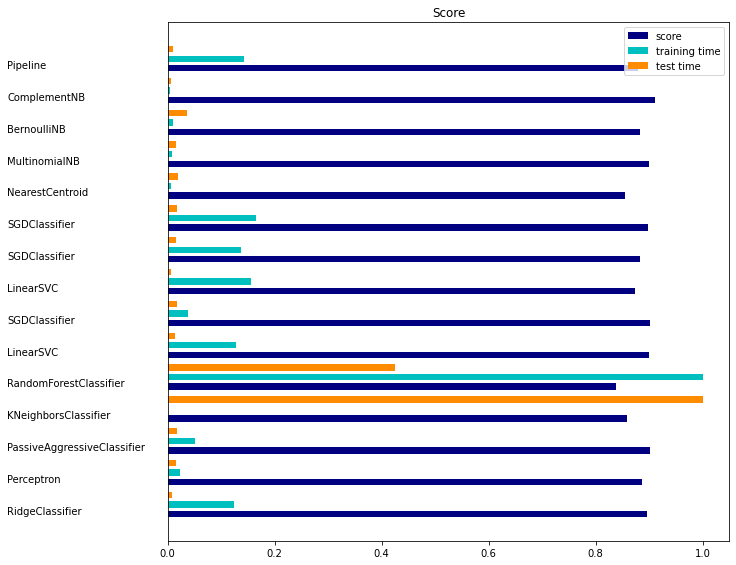

In [44]:
#plots
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

## Example: [Text doc clustering](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py)
- Clusters documents by topics using bag-of-words.
- Two feature extractors demo'd:
    - **TfidfVectorizer**: uses in-memory vocabulary (Python dict) to map words to feature indices, find a word frequency matrix, then re-weight the matrix using an inverse doc frequency (IDF) vector.
    - **HasingVectorizer**: hashes words to word counts in a fixed dimensional space (collisions are possible), normalizes the counts to have an L2-norm equal to one (projected to a Euclidean unit-ball). Does *not* provide IDF weighting - pipeline the output to a Transformer instance if it is needed.

- K-means and it scalable minibatch variant are used for comparison.

- LSA (latent semantic analysis can be used to reduce dimensionality.

- K-means is sensitive to feature scaling - IDF weighting helps to improve cluster quality.

- K-means is optimizing a non-convex function - it is likely to end up in a local optimium. Plan on using multiple runs.

In [45]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
import logging
from optparse import OptionParser
import sys
from time import time
import numpy as np

In [46]:
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

op = OptionParser()
op.add_option("--lsa",
              dest="n_components", 
              type="int",
              help="Preprocess documents with LSA.")
op.add_option("--no-minibatch",
              action="store_false", 
              dest="minibatch", 
              default=True,
              help="Use ordinary k-means")
op.add_option("--no-idf",
              action="store_false", 
              dest="use_idf", 
              default=True,
              help="Disable IDF feature weighting.")
op.add_option("--use-hashing",
              action="store_true", 
              default=False,
              help="Use hashing feature vectorizer")
op.add_option("--n-features", 
              type=int, 
              default=10000,
              help="Maximum #features (dimensions) to extract")
op.add_option("--verbose",
              action="store_true", 
              dest="verbose", 
              default=False,
              help="Print progress reports inside k-means.")

def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')

argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

In [47]:
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
# Uncomment the following to do the analysis on all the categories
# categories = None
dataset = fetch_20newsgroups(subset='all', 
                             categories=categories,
                             shuffle=True, 
                             random_state=42)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))

3387 documents
4 categories


In [48]:
labels = dataset.target
true_k = np.unique(labels).shape[0]

t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        hasher = HashingVectorizer(n_features     = opts.n_features,
                                   stop_words     = 'english', 
                                   alternate_sign = False,
                                   norm           = None)
        vectorizer = make_pipeline(hasher, 
                                   TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features     = opts.n_features,
                                       stop_words     = 'english',
                                       alternate_sign = False, 
                                       norm           = 'l2')
else:
    vectorizer = TfidfVectorizer(max_df       = 0.5, 
                                 max_features = opts.n_features,
                                 min_df       = 2, 
                                 stop_words   = 'english',
                                 use_idf      = opts.use_idf)
X = vectorizer.fit_transform(dataset.data)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)


done in 0.644545s
n_samples: 3387, n_features: 10000


In [49]:
if opts.n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

In [51]:
if opts.minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=opts.verbose)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=opts.verbose)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs            \t" 
      % (time() - t0))
print("Homogeneity: %0.3f        \t" 
      % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f       \t" 
      % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f          \t" 
      % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f \t"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f \t"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))


Clustering sparse data with MiniBatchKMeans(batch_size=1000, init_size=1000, n_clusters=4, n_init=1,
                verbose=False)
done in 0.089s            	
Homogeneity: 0.559        	
Completeness: 0.568       	
V-measure: 0.564          	
Adjusted Rand-Index: 0.548 	
Silhouette Coefficient: 0.007 	


In [52]:
if not opts.use_hashing:
    print("Top terms per cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')

Top terms per cluster:
Cluster 0: keith morality objective people say moral religion don think mathewCluster 1: space nasa access henry digex toronto pat gov alaska comCluster 2: god com sandvik jesus kent article people koresh apple sgiCluster 3: graphics university image thanks com posting host nntp file ac

## Example: [Topic extraction with NNMF & LDA](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py)
- NNMF is applied using two different objective functions:
    - Frobenius norm
    - generalized Kullback-Leibler divergence (equivalent to probabilistic LSA (?))
- Default params should complete in tens of seconds. Increasing dimensionality should increase time to complexity (NNMF: polynomial: LDA: #samples * #iterations).

In [53]:
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20

In [54]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

In [55]:
t0 = time()
data, _ = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'),
                             return_X_y=True)
data_samples = data[:n_samples]
print("done in %0.3fs." % (time() - t0))

done in 1.205s.


In [56]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

done in 0.233s.


In [57]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

Extracting tf features for LDA...
done in 0.238s.


In [58]:
# fit NMF model - Frobenius norm
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

done in 0.330s.


In [59]:
print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Topics in NMF model (Frobenius norm):
Topic #0: just people don think like know good time make way really say ve right want did ll new use years
Topic #1: windows use dos using window program os application drivers help software pc running ms screen files version work code mode
Topic #2: god jesus bible faith christian christ christians does sin heaven believe lord life mary church atheism love belief human religion
Topic #3: thanks know does mail advance hi info interested email anybody looking card help like appreciated information list send video need
Topic #4: car cars tires miles 00 new engine insurance price condition oil speed power good 000 brake year models used bought
Topic #5: edu soon send com university internet mit ftp mail cc pub article information hope email mac home program blood contact
Topic #6: file files problem format win sound ftp pub read save site image help available create copy running memory self version
Topic #7: game team games year win play season playe

In [60]:
# fit NMF model - Kullback-Leibler
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', 
          solver='mu', 
          max_iter=1000, 
          alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

done in 0.992s.


In [61]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))

Topic #0: people don think just right did like time say really know make said question course let way real things good
Topic #1: windows thanks help hi using looking does info software video use dos pc advance anybody mail appreciated card need know
Topic #2: god does jesus true book christian bible christians religion faith church believe read life christ says people lord exist say
Topic #3: thanks know bike interested car mail new like price edu heard list hear want cars email contact just com mark
Topic #4: 10 time year power 12 sale 15 new offer 20 30 00 16 monitor ve 11 14 condition problem 100
Topic #5: space government 00 nasa public security states earth phone 1993 research technology university subject information science data internet provide blood
Topic #6: edu file com program try problem files soon window remember sun win send library mike article just mit oh code
Topic #7: game team year games play world season won case division players win nhl flyers second toronto point

In [62]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))

Topic #0: people don think just right did like time say really know make said question course let way real things good
Topic #1: windows thanks help hi using looking does info software video use dos pc advance anybody mail appreciated card need know
Topic #2: god does jesus true book christian bible christians religion faith church believe read life christ says people lord exist say
Topic #3: thanks know bike interested car mail new like price edu heard list hear want cars email contact just com mark
Topic #4: 10 time year power 12 sale 15 new offer 20 30 00 16 monitor ve 11 14 condition problem 100
Topic #5: space government 00 nasa public security states earth phone 1993 research technology university subject information science data internet provide blood
Topic #6: edu file com program try problem files soon window remember sun win send library mike article just mit oh code
Topic #7: game team year games play world season won case division players win nhl flyers second toronto point

## Bag of Words Limitations
- Unigrams can't capture phrases & multiword expressions. It also can't handle misspellings or word derivations.
- N-Grams help solve this problem.
- Below: corpus of two documents. The 2nd doc contains a misspelling of "words".
- The vectorizer uses ```char_wb``` to vectorize look at characters inside word boundaries (whitespace).

In [63]:
ngram_vectorizer = CountVectorizer(analyzer='char_wb', 
                                   ngram_range=(2, 2))

counts = ngram_vectorizer.fit_transform(['words', 'wprds'])

print(ngram_vectorizer.get_feature_names() == (
    [' w', 'ds', 'or', 'pr', 'rd', 's ', 'wo', 'wp']))

# character-wise 2-gram model finds the document to match
# in 4 of 8 documents, which may indicate a better classifier.

print(counts.toarray().astype(int))

True
[[1 1 1 0 1 1 1 0]
 [1 1 0 1 1 1 0 1]]


- Below: ```char``` analyzer creates n-grams that span across words.

In [64]:
# char_wb
ngram_vectorizer = CountVectorizer(analyzer='char_wb', 
                                   ngram_range=(5, 5))

ngram_vectorizer.fit_transform(['jumpy fox'])

print(ngram_vectorizer.get_feature_names() == (
    [' fox ', ' jump', 'jumpy', 'umpy ']))

# char
ngram_vectorizer = CountVectorizer(analyzer='char', 
                                   ngram_range=(5, 5))
ngram_vectorizer.fit_transform(['jumpy fox'])

print(ngram_vectorizer.get_feature_names() == (
    ['jumpy', 'mpy f', 'py fo', 'umpy ', 'y fox']))

True
True


- ```char_wb``` is useful in languages that use whitespace for word separation - it generates less noise than ```chr```.
- Bag-of-words and Bag-of-ngrams techniques destroy most of the inner structure of documents - most of the meaning is lost. Retrieving this meaning is outside the scope of scikit-learn.

## Large text corpus vectorizing -- the hashing trick

- Above vectorization techniques require in-memory mapping = not feasible for large corpus datasets.
- [Hashing Vectorizer]() helps overcome this problem. It combines [Feature Hashing](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.FeatureHasher.html#sklearn.feature_extraction.FeatureHasher) with [Text Preprocessing & Tokenization (Count Vectorizer)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.FeatureHasher.html#sklearn.feature_extraction.FeatureHasher)

In [65]:
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=10)
hv.transform(corpus)

<4x10 sparse matrix of type '<class 'numpy.float64'>'
	with 16 stored elements in Compressed Sparse Row format>

- Real world: leave ```n_features``` at a default setting of ```2**20```. Reduce it if you see downstream memory or model size issues.
- Dimensionality does not affect training time of algorithms that use **CSR** matrices (LinearSVC(dual=True), Perceptron, SGDClassifier, PassiveAggressive), but does for algorithms that use **CSC** matrices (LinearSVC(dual=False), Lasso(), ...)

In [ ]:
# defaults - no collisions but much larger output space
hv = HashingVectorizer()
hv.transform(corpus)

## Out-of-core scaling
- HashingVectorizer can do out-of-core scaling using a mini-batch approach.

## Custom vectorizer classes
- ```preprocessor```: a function that transforms an entire document as a single string. This could be used to strip HTML, etc.
- ```tokenizer```: a function that splits the preprocessor's output into a list of tokens.
- ```analyzer```: a function that replaces the preprocessor & tokenizer - custom analyzers do this for you. 

In [67]:
def my_tokenizer(s):
    return s.split()

vectorizer = CountVectorizer(tokenizer=my_tokenizer)
vectorizer.build_analyzer()(u"Some... punctuation!") == (
    ['some...', 'punctuation!'])

True

## Tips:
- If documents are pre-tokenized by an external package, store them in files with tokens separated by whitespace. Pass ```analyzer=str.split```.
- Advanced analysis (stemming, lemmatizing, ...) are not included in scikit-learn but can be added using custom tokenizers or analyzers.

In [68]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

vect = CountVectorizer(tokenizer=LemmaTokenizer())

In [69]:
# transform British spelling to American spelling
import re
def to_british(tokens):
    for t in tokens:
        t = re.sub(r"(...)our$", r"\1or", t)
        t = re.sub(r"([bt])re$", r"\1er", t)
        t = re.sub(r"([iy])s(e$|ing|ation)", r"\1z\2", t)
        t = re.sub(r"ogue$", "og", t)
        yield t

class CustomVectorizer(CountVectorizer):
    def build_tokenizer(self):
        tokenize = super().build_tokenizer()
        return lambda doc: list(to_british(tokenize(doc)))

print(CustomVectorizer().build_analyzer()(u"color colour"))

['color', 'color']
